# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flow-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine and there are assembly operations with arbitrary machine precedences.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & h_{i,k} + \sum_{j \in J} p_{j,i} x_{j,k} \leq h_{j,k}
         & \forall ~ (i,j) \in E; k \in K\\
     & h_{m,k} + \sum_{j \in J} p_{j,m} x_{j,k} \leq h_{m,k+1}
         & \forall ~ m \in M; k \in K \setminus \{|K|\}\\
     & \sum_{j \in J} x_{j,k} = 1
         & \forall ~ k \in K\\
     & \sum_{k \in K} x_{j,k} = 1
         & \forall ~ j \in J\\
     & h_{m,|K|} + \sum_{j \in J} p_{j,m} x_{j,|K|} \leq C_{\text{max}}
         & \forall ~ m \in M\\
     & h_{m,k} \geq 0 & \forall ~ m \in M; k \in K\\
     & x_{j,k} \in \{0, 1\} & \forall ~ j \in J; k \in K\\
 \end{align}
 $$

Where $E$ represents the set of directed edges $(i,j)$ indicating that machine $i$ must precede machine $j$ in the processing sequence.

You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [ ]:
import gc
import json
import os

from bnbprob.pafssp import CallbackBnB, PermFlowShop, plot_gantt
from bnbprob.pafssp.instances import AssemblyFlowShopInstance
from bnbpy import configure_logfile

In [ ]:
configure_logfile("pafssp-bench.log", mode="w")

In [3]:
gc.disable()

## DPm -> Fm || Cmax

In [16]:
file = 'dpm-013-20-5x9.json'
input_path = './../data/pafssp/dpm'

name = file[:-5]
with open(os.path.join(input_path, file), 'r', encoding='utf8') as f:
    data = json.load(f)
instance = AssemblyFlowShopInstance(data["p"], data["edges"])

In [17]:
problem = PermFlowShop.from_p(instance.p, edges=instance.edges)
bnb = CallbackBnB(eval_node="in", rtol=0.0001, save_tree=False)

In [18]:
sol = bnb.solve(problem, maxiter=10_000_000, timelimit=300)
print(sol)

Status: OPTIMAL | Cost: 1637.0 | LB: 1637.0


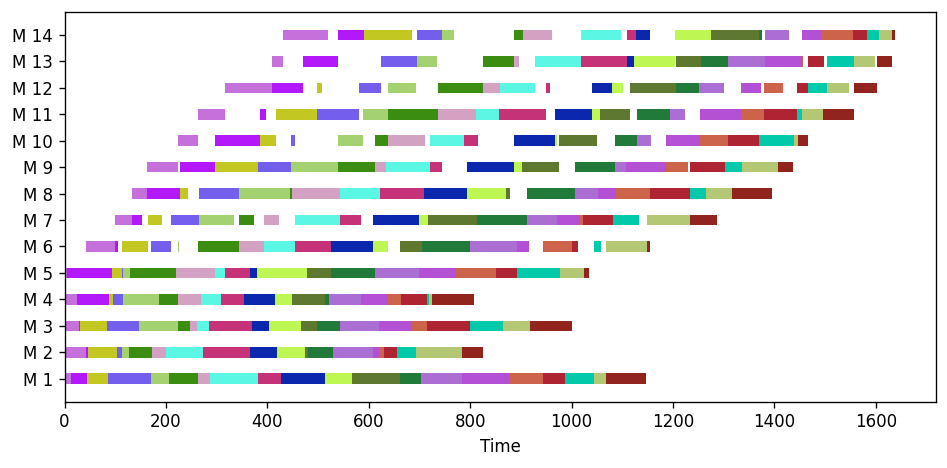

In [19]:
plot_gantt(sol.problem.sequence, dpi=120, seed=42, figsize=[8, 4])

## Parallel Semilines Layout

In [12]:
file = 'd2f-012-20-10x10.json'
input_path = './../data/pafssp/d2f'

name = file[:-5]
with open(os.path.join(input_path, file), 'r', encoding='utf8') as f:
    data = json.load(f)
instance = AssemblyFlowShopInstance(data["p"], data["edges"])

In [16]:
problem = PermFlowShop.from_p(instance.p, edges=instance.edges)
bnb = CallbackBnB(eval_node="in", rtol=0.0001, save_tree=False)

In [17]:
sol = bnb.solve(problem, maxiter=10_000_000, timelimit=30)
print(sol)

Status: OPTIMAL | Cost: 1703.0 | LB: 1703.0


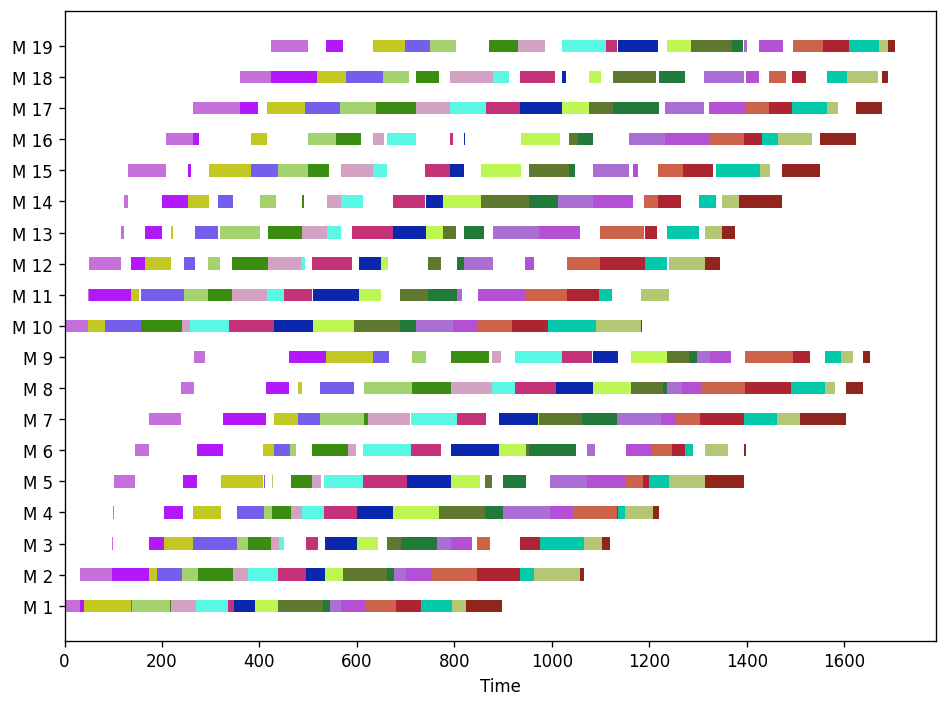

In [19]:
plot_gantt(sol.problem.sequence, dpi=120, seed=42, figsize=[8, 6])

In this implmentation lower bounds are computed by
the max of a single machine and
a two machine relaxations.

The bounds for single and two-machine problems are described
by Potts (1980), also implemented by Ladhari & Haouari (2005),
therein described as 'LB1' and 'LB5'.

If the attribute `constructive` is 'neh', the heuristic
of Nawaz et al. (1983) is adopted, otherwise
the strategy by Palmer (1965).


## References

Ladhari, T., & Haouari, M. (2005). A computational study of
the permutation flow shop problem based on a tight lower bound.
Computers & Operations Research, 32(7), 1831-1847.

Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983).
A heuristic algorithm for the m-machine,
n-job flow-shop sequencing problem.
Omega, 11(1), 91-95.

Potts, C. N. (1980). An adaptive branching rule for the permutation
flow-shop problem. European Journal of Operational Research, 5(1), 19-25.

Palmer, D. S. (1965). Sequencing jobs through a multi-stage process
in the minimum total time—a quick method of obtaining a near optimum.
Journal of the Operational Research Society, 16(1), 101-107

## Bonus - MILP Model

This is the usual Position-based MILP model as an alternative to compare performance.


```python
import pyomo.environ as pyo

from bnbprob.pfssp.mip import positional_model

model = positional_model(p)


# HiGHS
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.1
solver.options["time_limit"] = 120
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)
```